# Generating adversarial examples (FGSM)

Performing adversarial attacks using the FGSM algorithm.

In [61]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import pretrained model: MobleNetV2
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [62]:
# Helper function to preprocess the image 
# so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image / 255
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top = 1)[0][0]

In [63]:
# Load target image
image_path = tf.keras.utils.get_file('weibo_cat.jpg', 'https://wx1.sinaimg.cn/mw600/bd2e17b6ly1gbrmve3krfj21400u0tkq.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

# Preprocess image and predict with model
image = preprocess(image)
image_probs = pretrained_model.predict(image)

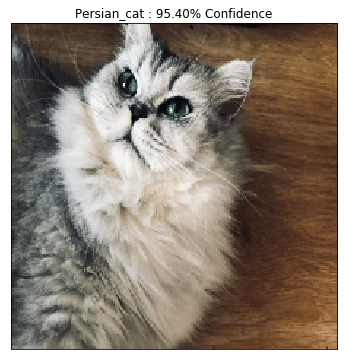

In [64]:
# Show target image
plt.figure(figsize=(6, 6))
plt.xticks([])
plt.yticks([])
plt.imshow(image[0])

# Get image predicted label and confidence
_, image_class, class_confidence = get_imagenet_label(image_probs)

# Show image label and predicted confidence
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence * 100))
plt.show()

## Implementing the FGSM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


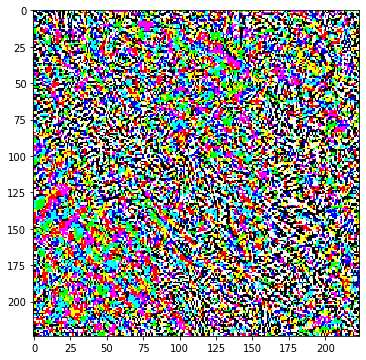

In [65]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Create adversarial pattern with FGSM
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
    
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

# Get the input label of the image.
persian_cat_index = 283

label = tf.one_hot(persian_cat_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

# Create perturbations
perturbations = create_adversarial_pattern(image, label)
# Visualize perturbations
plt.figure(figsize=(6, 6))
plt.imshow(perturbations[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


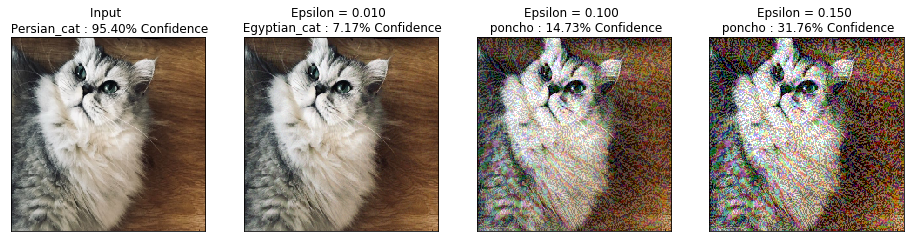

In [66]:
# Enumerate epsilons
epsilons = [0, 0.01, 0.1, 0.15]
# Enumerate image epsilon titles
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

# Plot images, images with adversarial patterns and 
# corresponding predicted labels with confidence
plt.figure(figsize=(len(epsilons) * 4, 4))

# Display subplots
def display_images(image, description, i):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.subplot(1, len(epsilons), i)
    plt.imshow(image[0])
    plt.xticks([])
    plt.yticks([])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence * 100))
    
# Enumerate through epsilons, creating images with adversaral patterns
for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_y = tf.clip_by_value(adv_x, 0, 1)
    display_images(adv_x, descriptions[i], i + 1)

plt.show()